# Predicción de categoria de productos

### Links

- [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)
- [Best models](https://huggingface.co/models)

In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd
import torch
from   torch import nn

import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-08-28 16:27:55,788 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Fijamos la semilla:

In [1]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [9]:
set_seed(42)

Parametros de la notebook:

In [1]:
DATASET_PATH       = '../../datasets'
WEIGHTS_PATH       = '../../weights'
MODEL_WEIGHTS_PATH = f'{WEIGHTS_PATH}/model_weights.h5'

!mkdir -p {WEIGHTS_PATH}

Modelo pre entrenado a utilizar. Este es una capa/module mas de nuestro modelo:

In [3]:
BERT_MODEL ='bert-base-cased'
# BERT_MODEL ='distilbert-base-uncased'
# BERT_MODEL ='albert-base-v2'

## Cargar dataset

In [12]:
train_set = pd.read_csv(f'{DATASET_PATH}/ebay-train.csv')
val_set   = pd.read_csv(f'{DATASET_PATH}/ebay-val.csv')
test_set  = pd.read_csv(f'{DATASET_PATH}/ebay-test.csv')

In [13]:
train_set.head()

,title,category,category_seq
0,2009 Chevrolet Aveo 1.2 LS 5dr Engine Control ...,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,32
1,1pz Front Shock Absorber SX JAPANPARTS Mm-10068,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,16
2,Mintex MDC2808C Brake Disc,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,49
3,Gates T39145 Tensioner,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,87
4,Gimbal Camera Lens Protector Cover Cap Accesso...,eBay ~ Toys & Games ~ Radio Control & RC Toys ...,5


Tamaño máximo de la secuencia de entrada:

In [14]:
max_length = 2 + train_set['title'].apply(len).max()
max_length

146

In [15]:
tokenizer = ml.Tokenizer(
    BERT_MODEL,
    padding    = 'max_length',
    max_length = max_length
)

In [16]:
train_dataset = dt.BertDataset(
    train_set,
    feature_col = 'title', 
    target_col  = 'category_seq',
    tokenizer   = tokenizer
)

val_dataset = dt.BertDataset(
    val_set,
    feature_col = 'title', 
    target_col  = 'category_seq',
    tokenizer   = tokenizer
)

test_dataset = dt.BertDataset(
    test_set,
    feature_col = 'title', 
    target_col  = 'category_seq',
    tokenizer   = tokenizer
)

Cantidad de clases a predecir:

In [17]:
n_classes = train_set['category'].unique().shape[0]
n_classes

122

In [18]:
classifier = ml.BertClassifier(
    output_dim = n_classes,
    model      = BERT_MODEL,
    dropout    = 0.1
)

## Entrenamiento y evaluación

In [19]:
classifier.load(MODEL_WEIGHTS_PATH)

In [20]:
model = ml.BertModel(
    classifier,
    batch_size = 25,
    criterion  = nn.CrossEntropyLoss(), 
    optimizer  = torch.optim.Adam(classifier.parameters(), lr = 0.0000001)
)

In [26]:
model.fit(train_dataset, val_dataset, epochs=2)

2022-08-28 16:37:42,651 - INFO - Time: 0:00:12.30 | Epoch: 1 | Train(loss: 0.003595, acc: 99.94%) | Val(loss: 0.037137, acc: 82.47%) | acc diff: 17.47%
2022-08-28 16:37:54,926 - INFO - Time: 0:00:12.27 | Epoch: 2 | Train(loss: 0.003462, acc: 99.94%) | Val(loss: 0.037409, acc: 83.51%) | acc diff: 16.44%


{'loss': 0.003462247916345029, 'acc': 0.9994222992489891}

In [30]:
classifier.save(MODEL_WEIGHTS_PATH)

In [113]:
summary = model.validate(test_dataset)

In [114]:
summary.accuracy, summary.loss

(0.78125, 0.1301768310368061)

In [115]:
summary.targets

[
    array([ 24,   0, 103,  14,  76,  87,  48,  37,   4,  16]),
    array([ 86,  22,  57,   7,  21,   9,   0, 106,  32,  97]),
    array([34, 36,  0, 20, 40, 30, 45, 15, 26, 52]),
    array([ 0, 46,  7, 16, 51, 77,  6, 81, 89,  0]),
    array([ 48, 121,  11,  55,  22,   0,   0, 105,  49,  64]),
    array([ 3, 92, 11,  0,  1, 64, 61, 16, 77, 49]),
    array([110,   5,  27,   0, 109, 114,   0,  99,  33,  34]),
    array([ 32,  95, 112,  58,  51,  64,  58,  16,   6, 120]),
    array([ 98,  94,  29, 111,  65,  77,  60,   3, 104,  51]),
    array([29,  2, 35, 11, 89, 11])
]

In [116]:
summary.predictions

[
    array([24,  0, 68, 14, 76, 87, 48,  9,  4, 16]),
    array([ 86,  22,  57,   7,  21,   9,   0, 110,   3,  97]),
    array([34, 36,  0, 30, 40, 66, 45, 15, 92, 89]),
    array([77,  6,  7, 16, 51, 77,  6, 81, 89,  0]),
    array([ 48, 121,  11,  30,  22,   0,   0,  21,  49,  64]),
    array([ 3, 92, 11,  0,  0, 64, 61, 16, 77, 49]),
    array([110,  49,  27,   0,  14,  14,   0,  99,  33,  64]),
    array([ 98,  95, 112,  58,  51,  64,  58,  16,   6, 120]),
    array([ 16,  39,  29, 103,  65,  77,  60,   3, 104,  51]),
    array([29,  2, 35, 11, 89, 11])
]

In [122]:
np.concatenate(summary.predictions).shape

(96,)

<Figure size 360x360 with 2 Axes>

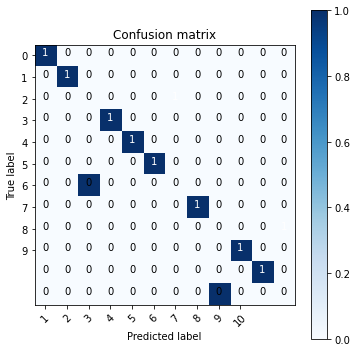

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         0
          14       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         1
          37       0.00      0.00      0.00         1
          48       1.00      1.00      1.00         1
          68       0.00      0.00      0.00         0
          76       1.00      1.00      1.00         1
          87       1.00      1.00      1.00         1
         103       0.00      0.00      0.00         1

    accuracy                           0.80        10
   macro avg       0.67      0.67      0.67        10
weighted avg       0.80      0.80      0.80        10



In [132]:
summary.show_sample_metrics(0)

<Figure size 360x360 with 2 Axes>

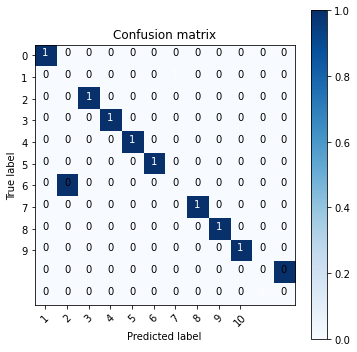

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           7       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          21       1.00      1.00      1.00         1
          22       1.00      1.00      1.00         1
          32       0.00      0.00      0.00         1
          57       1.00      1.00      1.00         1
          86       1.00      1.00      1.00         1
          97       1.00      1.00      1.00         1
         106       0.00      0.00      0.00         1
         110       0.00      0.00      0.00         0

    accuracy                           0.80        10
   macro avg       0.67      0.67      0.67        10
weighted avg       0.80      0.80      0.80        10



In [131]:
summary.show_sample_metrics(1)

<Figure size 1800x1800 with 2 Axes>

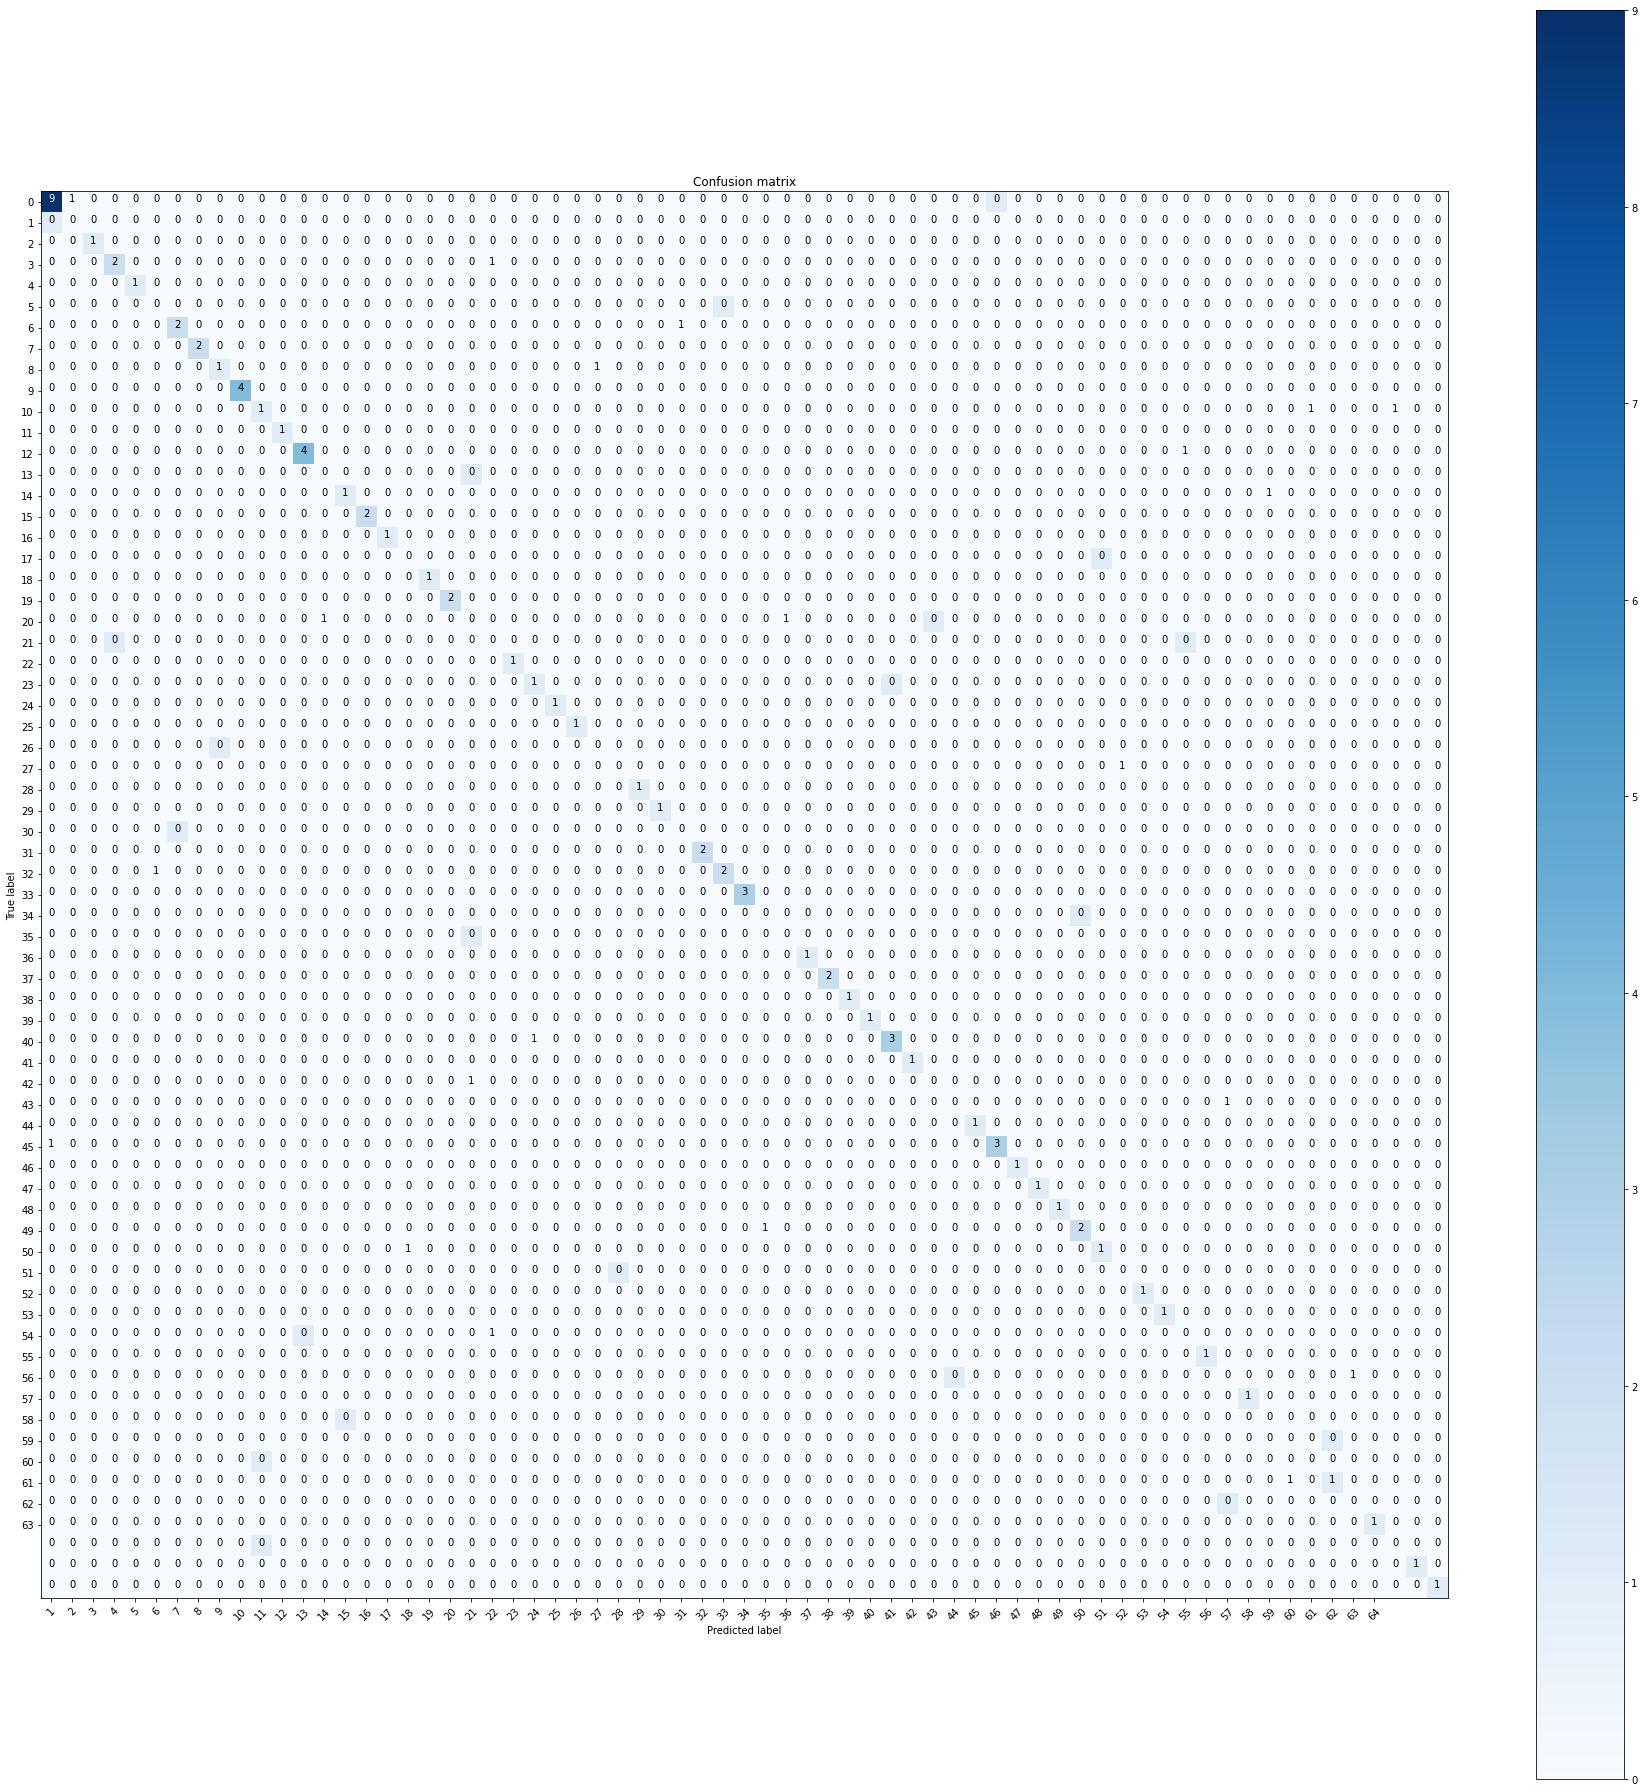

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         1
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         2
           9       0.50      1.00      0.67         1
          11       1.00      1.00      1.00         4
          14       0.33      1.00      0.50         1
          15       1.00      1.00      1.00         1
          16       0.80      1.00      0.89         4
          20       0.00      0.00      0.00         1
          21       0.50      1.00      0.67         1
          22       1.00      1.00      1.00         2
          24       1.00      1.00      1.00         1
          26       0.00    

In [134]:
summary.show_metrics()